<a href="https://colab.research.google.com/github/kalinkabel/visao-computacional-analises-medicas/blob/main/Projeto_Cancer_Pele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalando e Carregando os Pacotes

In [ ]:
# Imports

# Manipulação de dados e imagens
import os
import cv2
import itertools
from tqdm import tqdm
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Pytorch para preparação dos dados, criação e treino do modelo
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# Scikit-learn para divisão dos dados e avaliação do modelo
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Carregando e Compreendendo os Metadados

Acesse o item de dicionário de dados no Capítulo 8.

In [ ]:
# Leitura do arquivo de metadados
df_inicial = pd.read_csv(os.path.join('dados_HAM', 'HAM10000_metadata.csv'))

In [ ]:
df_inicial.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df_inicial.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [ ]:
# Caminho para as imagens
caminho_imagens = glob(os.path.join('dados_HAM', '*', '*.jpg'))

In [ ]:
# Cria um dicionário com id da imagem e caminho do arquivo no disco
dict_imagens = {os.path.splitext(os.path.basename(x))[0]: x for x in caminho_imagens}

In [ ]:
# Imprimimos 5 registros do dicionário
dict(itertools.islice(dict_imagens.items(), 5))

{'ISIC_0026629': 'dados_HAM/HAM10000_images_part_1/ISIC_0026629.jpg',
 'ISIC_0024384': 'dados_HAM/HAM10000_images_part_1/ISIC_0024384.jpg',
 'ISIC_0025840': 'dados_HAM/HAM10000_images_part_1/ISIC_0025840.jpg',
 'ISIC_0027638': 'dados_HAM/HAM10000_images_part_1/ISIC_0027638.jpg',
 'ISIC_0025781': 'dados_HAM/HAM10000_images_part_1/ISIC_0025781.jpg'}

In [ ]:
# Adiciona o path ao df_inicial
df_inicial['path'] = df_inicial['image_id'].map(dict_imagens.get)

In [ ]:
df_inicial.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dados_HAM/HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
# Tipos de lesões que serão analisadas
tipo_lesao_dict = {'nv': 'Melanocytic nevi',
                   'mel': 'Melanoma',
                   'bkl': 'Benign keratosis-like',
                   'bcc': 'Basal cell carcinoma',
                   'akiec': 'Actinic keratoses',
                   'vasc': 'Vascular lesions',
                   'df': 'Dermatofibroma'}

Referência:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7445643/

In [ ]:
# Extrair o tipo de lesão
df_inicial['tipo_lesao'] = df_inicial['dx'].map(tipo_lesao_dict.get)

In [ ]:
df_inicial.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dados_HAM/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like


In [ ]:
# Converte a variável categórica em sua representação numérica
df_inicial['tipo_lesao_idx'] = pd.Categorical(df_inicial['tipo_lesao']).codes

In [ ]:
df_inicial.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,dados_HAM/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,dados_HAM/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like,2


In [ ]:
df_inicial.tipo_lesao_idx.unique()

array([2, 4, 3, 5, 6, 1, 0], dtype=int8)

In [ ]:
df_inicial.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx
2719,HAM_0002312,ISIC_0025650,bcc,histo,70.0,male,face,dados_HAM/HAM10000_images_part_1/ISIC_0025650.jpg,Basal cell carcinoma,1
2783,HAM_0005971,ISIC_0031258,bcc,histo,40.0,male,back,dados_HAM/HAM10000_images_part_2/ISIC_0031258.jpg,Basal cell carcinoma,1
2362,HAM_0000940,ISIC_0033969,vasc,histo,35.0,female,lower extremity,dados_HAM/HAM10000_images_part_2/ISIC_0033969.jpg,Vascular lesions,6
2344,HAM_0004455,ISIC_0027385,vasc,histo,20.0,male,trunk,dados_HAM/HAM10000_images_part_1/ISIC_0027385.jpg,Vascular lesions,6
9352,HAM_0000741,ISIC_0025956,nv,consensus,35.0,male,back,dados_HAM/HAM10000_images_part_1/ISIC_0025956.jpg,Melanocytic nevi,4


## Pré-Processamento

Vamos pré-processar as imagens.

### 1- Extraindo Média e Desvio Padrão das Imagens

Esta função é usada para calcular a média e o desvio padrão em todo o conjunto de dados e será usada para normalização das imagens de entrada.

In [ ]:
# Função para cálculo de média e desvio
def dsa_func_calcula_img_mean_std(image_paths):

    # Define altura e largura que usaremos nas imagens
    img_h, img_w = 224, 224

    # Listas de controle
    imgs = []
    means, stdevs = [], []

    # Loop de leitura e resize das imagens
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    # Stack de imagens
    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    # Normalização
    imgs = imgs.astype(np.float32) / 255.

    # Loop de cálculo da média e desvio
    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    # BGR --> RGB
    means.reverse()
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))

    return means, stdevs

In [ ]:
%%time

# Retorna a média e o desvio padrão de cada canal RGB
norm_mean, norm_std = dsa_func_calcula_img_mean_std(caminho_imagens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [00:42<00:00, 235.75it/s]


(224, 224, 3, 10015)
normMean = [0.76304126, 0.5456457, 0.5700472]
normStd = [0.14092818, 0.15261303, 0.16997096]
CPU times: user 50.6 s, sys: 2.92 s, total: 53.5 s
Wall time: 53.5 s


### 2- Preparação do Dataset de Validação

In [ ]:
# Vamos verificar quantas imagens estão associadas a cada lesion_id
df_temp = df_inicial.groupby('lesion_id').count()

In [ ]:
df_temp.head()

,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx
lesion_id,,,,,,,,,
HAM_0000000,2,2,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1,1,1


In [ ]:
# Agora filtramos lesion_ids que possuem apenas uma imagem associada
df_temp = df_temp[df_temp['image_id'] == 1]

In [ ]:
# Reset do índice
df_temp.reset_index(inplace = True)

In [ ]:
df_temp.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [ ]:
# Função para identificar lesion_ids que possuem imagens duplicadas e aqueles que possuem apenas uma imagem
def dsa_get_duplicates(x):
    unique_list = list(df_temp['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

In [ ]:
# Cria uma nova coluna que seja uma cópia da coluna lesion_id
df_inicial['duplicates'] = df_inicial['lesion_id']

In [ ]:
df_inicial.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx,duplicates
5946,HAM_0004361,ISIC_0030515,nv,follow_up,45.0,male,foot,dados_HAM/HAM10000_images_part_2/ISIC_0030515.jpg,Melanocytic nevi,4,HAM_0004361
7441,HAM_0000747,ISIC_0033748,nv,histo,30.0,male,trunk,dados_HAM/HAM10000_images_part_2/ISIC_0033748.jpg,Melanocytic nevi,4,HAM_0000747
6463,HAM_0003563,ISIC_0030075,nv,follow_up,40.0,female,abdomen,dados_HAM/HAM10000_images_part_2/ISIC_0030075.jpg,Melanocytic nevi,4,HAM_0003563


In [ ]:
# Aplica a função a esta nova coluna
df_inicial['duplicates'] = df_inicial['duplicates'].apply(dsa_get_duplicates)

In [ ]:
df_inicial.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx,duplicates
2326,HAM_0002692,ISIC_0029404,vasc,histo,10.0,male,trunk,dados/HAM10000_images_part_2/ISIC_0029404.jpg,Vascular lesions,6,duplicated
3052,HAM_0001061,ISIC_0029526,nv,follow_up,45.0,male,back,dados/HAM10000_images_part_2/ISIC_0029526.jpg,Melanocytic nevi,4,unduplicated
2837,HAM_0004827,ISIC_0027819,bcc,histo,50.0,female,back,dados/HAM10000_images_part_1/ISIC_0027819.jpg,Basal cell carcinoma,1,unduplicated
2743,HAM_0004880,ISIC_0028583,bcc,histo,65.0,male,back,dados/HAM10000_images_part_1/ISIC_0028583.jpg,Basal cell carcinoma,1,unduplicated
3691,HAM_0004964,ISIC_0028062,nv,follow_up,30.0,male,scalp,dados/HAM10000_images_part_1/ISIC_0028062.jpg,Melanocytic nevi,4,unduplicated


In [ ]:
# Vamos contar as duplicatas
df_inicial['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [ ]:
# Agora filtramos as imagens que não têm duplicatas
df_temp = df_inicial[df_inicial['duplicates'] == 'unduplicated']

In [ ]:
df_temp.shape

(5514, 11)

In [ ]:
# Definimos y
y = df_temp['tipo_lesao_idx']

In [ ]:
# Agora criamos o dataset de validação com 20% das imagens usando df_temp
# porque temos certeza de que nenhuma dessas imagens tem duplicatas
_, df_val = train_test_split(df_temp, test_size = 0.2, random_state = 101, stratify = y)

In [ ]:
df_val.shape

(1103, 11)

In [ ]:
df_val['tipo_lesao_idx'].value_counts()

tipo_lesao_idx
4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: count, dtype: int64

### 3- Separação das Amostras de Treino e Validação

In [ ]:
# Esta função identifica se uma imagem faz parte do conjunto train ou val
def dsa_get_val_rows(x):
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'valid'
    else:
        return 'treino'

In [ ]:
# Identifica treino ou validação
df_inicial['treino_ou_valid'] = df_inicial['image_id']

In [ ]:
# Aplica a função a esta nova coluna
df_inicial['treino_ou_valid'] = df_inicial['treino_ou_valid'].apply(dsa_get_val_rows)

In [ ]:
df_inicial.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,tipo_lesao,tipo_lesao_idx,duplicates,treino_ou_valid
7824,HAM_0007433,ISIC_0033149,nv,histo,45.0,male,back,dados/HAM10000_images_part_2/ISIC_0033149.jpg,Melanocytic nevi,4,duplicated,treino
3103,HAM_0000408,ISIC_0027000,nv,follow_up,45.0,female,lower extremity,dados/HAM10000_images_part_1/ISIC_0027000.jpg,Melanocytic nevi,4,unduplicated,treino
3495,HAM_0000768,ISIC_0028242,nv,follow_up,35.0,male,back,dados/HAM10000_images_part_1/ISIC_0028242.jpg,Melanocytic nevi,4,unduplicated,treino
9498,HAM_0003968,ISIC_0032796,nv,consensus,35.0,female,back,dados/HAM10000_images_part_2/ISIC_0032796.jpg,Melanocytic nevi,4,duplicated,treino
175,HAM_0006801,ISIC_0032688,bkl,histo,60.0,female,lower extremity,dados/HAM10000_images_part_2/ISIC_0032688.jpg,Benign keratosis-like,2,duplicated,treino
9387,HAM_0000698,ISIC_0027431,nv,consensus,NaN,male,foot,dados/HAM10000_images_part_1/ISIC_0027431.jpg,Melanocytic nevi,4,duplicated,treino
3188,HAM_0000789,ISIC_0028932,nv,follow_up,40.0,male,abdomen,dados/HAM10000_images_part_1/ISIC_0028932.jpg,Melanocytic nevi,4,unduplicated,treino
5786,HAM_0003270,ISIC_0025764,nv,follow_up,35.0,male,back,dados/HAM10000_images_part_1/ISIC_0025764.jpg,Melanocytic nevi,4,unduplicated,treino
7830,HAM_0006121,ISIC_0032855,nv,histo,20.0,female,chest,dados/HAM10000_images_part_2/ISIC_0032855.jpg,Melanocytic nevi,4,duplicated,treino
1133,HAM_0002895,ISIC_0029578,df,histo,60.0,male,lower extremity,dados/HAM10000_images_part_2/ISIC_0029578.jpg,Dermatofibroma,3,unduplicated,valid


In [ ]:
# Filtra as linhas de treino
df_treino = df_inicial[df_inicial['treino_ou_valid'] == 'treino']

In [ ]:
print(len(df_treino))

8912


In [ ]:
print(len(df_val))

1103


In [ ]:
df_treino['tipo_lesao_idx'].value_counts()

tipo_lesao_idx
4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: count, dtype: int64

In [ ]:
df_treino['tipo_lesao'].value_counts()

tipo_lesao
Melanocytic nevi         5822
Melanoma                 1067
Benign keratosis-like    1011
Basal cell carcinoma      479
Actinic keratoses         297
Vascular lesions          129
Dermatofibroma            107
Name: count, dtype: int64

In [ ]:
df_val['tipo_lesao'].value_counts()

tipo_lesao
Melanocytic nevi         883
Benign keratosis-like     88
Melanoma                  46
Basal cell carcinoma      35
Actinic keratoses         30
Vascular lesions          13
Dermatofibroma             8
Name: count, dtype: int64

### 4- Dataset Augmentation Para Balanceamento de Classe

Podemos ver que há um sério desequilíbrio de classe nos dados de treinamento. Para resolver esse problema faremos um balanceamento de classes aumentando a quantidade das classes minoritárias (oversampling). Outra alternativa seria reduzir as classes majoritárias (undersampling).

In [ ]:
# Contagem de registros por classe
df_treino['tipo_lesao_idx'].value_counts().sort_index()

tipo_lesao_idx
0     297
1     479
2    1011
3     107
4    5822
5    1067
6     129
Name: count, dtype: int64

In [ ]:
# Taxa de dataset augmentation a ser usada em cada classe
data_aug_rate = [15,10,5,40,0,5,15]

In [ ]:
# Inicia um loop que iterará 7 vezes (pelas 7 classes de imagens)
for i in range(7):

    # Verifica se existe uma taxa de aumento de dados especificada para a classe i
    if data_aug_rate[i]:

        # Se houver, repete as linhas da classe i conforme a taxa especificada em data_aug_rate[i]
        # Concatena múltiplas cópias das linhas da classe i para aumentar artificialmente o conjunto de dados
        rows_to_add = pd.concat([df_treino.loc[df_treino['tipo_lesao_idx'] == i, :]] * (data_aug_rate[i] - 1),
                                ignore_index = True)

        # Adiciona as novas linhas ao DataFrame de treino, aumentando o número de exemplos para a classe i
        df_treino = pd.concat([df_treino,
                               rows_to_add],
                              ignore_index = True)

In [ ]:
df_treino['tipo_lesao'].value_counts()

tipo_lesao
Melanocytic nevi         5822
Melanoma                 5335
Benign keratosis-like    5055
Basal cell carcinoma     4790
Actinic keratoses        4455
Dermatofibroma           4280
Vascular lesions         1935
Name: count, dtype: int64

In [ ]:
# Reset do índice
df_treino = df_treino.reset_index()

In [ ]:
df_treino.shape

(31672, 13)

### 5- Preparação das Amostras de Treino, Validação e Teste

In [ ]:
# Podemos dividir o conjunto de validação em um conjunto de validação e um conjunto de teste
df_val, df_teste = train_test_split(df_val, test_size = 0.5)

In [ ]:
# Reset do índice
df_val = df_val.reset_index()
df_teste = df_teste.reset_index()

In [ ]:
df_val.shape

(551, 12)

In [ ]:
df_teste.shape

(552, 12)

In [ ]:
df_treino.shape

(31672, 13)

### 6- Transformações das Imagens

In [ ]:
# Tamanho (pixels) das imagens de entrada (tamanho usado no modelo DenseNet)
input_size = 224

In [ ]:
# Transformações das imagens de treino
transform_treino = transforms.Compose([transforms.Resize((input_size, input_size)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ColorJitter(brightness = 0.1, contrast = 0.1, hue = 0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(norm_mean, norm_std)])

In [ ]:
# Transformações das imagens de validação
transform_val = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [ ]:
# Carrega o módulo de organização dos dados
from dsa_organiza_dados import OrganizaDados

In [ ]:
# Organiza e transforma os dados de treino
set_treino = OrganizaDados(df_treino, transform = transform_treino)

In [ ]:
# O mesmo em validação
set_val = OrganizaDados(df_val, transform = transform_val)

In [ ]:
# O mesmo em teste
set_teste = OrganizaDados(df_teste, transform = transform_val)

### 7- Criação dos DataLoaders

In [ ]:
# Cria o dataloader de treino
loader_treino = DataLoader(set_treino, batch_size = 32, shuffle = True, num_workers = 4)

In [ ]:
# Cria o dataloader de validação
loader_val = DataLoader(set_val, batch_size = 32, shuffle = False, num_workers = 4)

In [ ]:
# Cria o dataloader de teste
loader_teste = DataLoader(set_teste, batch_size = 32, shuffle = False, num_workers = 4)

## Modelagem - Construção do Modelo de Deep Learning

Veja a descrição da arquitetura DenseNet no videobook no Capítulo 8 do curso.

https://pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html

In [ ]:
# Define o número de classes
num_classes = 7

In [ ]:
# Carregamos o modelo pré-treinado com todos os pesos
modelo_densenet = models.densenet121(pretrained = True)

In [ ]:
# Define o número de atributos de entrada
num_ftrs = modelo_densenet.classifier.in_features

In [ ]:
num_ftrs

1024

In [ ]:
# Camada linear final para prever a probabilidade das 7 classes com as quais estamos trabalhando
modelo_densenet.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
# Verificando o dispositivo
processing_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Define o device
device = processing_device

In [ ]:
print(device)

cuda


In [ ]:
# Coloca o modelo no device
modelo = modelo_densenet.to(device)

In [ ]:
# Usaremos o otimizador Adam
optimizer = optim.Adam(modelo.parameters(), lr = 1e-3)

In [ ]:
# Usaremos cross entropy loss como função de perda
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
print(modelo)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Treinamento do Modelo

Vamos executar as etapas necesárias para treinar o modelo.

### Funções Para o Loop de Treino e Validação

In [ ]:
# Função para calcular erro em treino e validação durante o treinamento
class DSACalculaMetricas(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Listas para erro e acurácia em treino
total_loss_train, total_acc_train = [],[]

In [ ]:
# Função de treino do modelo
def dsa_treina_modelo(treino_loader, model, criterion, optimizer, epoch):

    # Coloca o modelo em modo de treino
    model.train()

    # Inicializa objetos de cálculo de métricas
    train_loss = DSACalculaMetricas()
    train_acc = DSACalculaMetricas()

    # Iteração
    curr_iter = (epoch - 1) * len(treino_loader)

    # Loop de treino
    for i, data in enumerate(treino_loader):

        # Extra os dados
        images, labels = data

        # Tamanho da imagem
        N = images.size(0)

        # Coloca imagens e labels no device
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Zera os gradientes
        optimizer.zero_grad()

        # Previsão do modelo
        outputs = model(images)

        # Erro do modelo
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Obtem a previsão de maior probabilidade
        prediction = outputs.max(1, keepdim = True)[1]

        # Atualiza as métricas
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())

        # Iteração
        curr_iter += 1

        # Print e update das métricas
        if (i + 1) % 100 == 0 and curr_iter < 1000:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (epoch,
                                                                                       i + 1,
                                                                                       len(treino_loader),
                                                                                       train_loss.avg,
                                                                                       train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)

    # Salva o modelo em disco
    torch.save(model, 'modelos/modelo_dsa.pth')

    return train_loss.avg, train_acc.avg

In [ ]:
# Listas para erro e acurácia em validação
total_loss_val, total_acc_val = [],[]

In [ ]:
# Função para validação
def dsa_valida_modelo(val_loader, model, criterion, optimizer, epoch):

    # Coloca o modelo em modo de validação
    model.eval()

    # Inicializa objetos de cálculo de métricas
    val_loss = DSACalculaMetricas()
    val_acc = DSACalculaMetricas()

    # Validação
    with torch.no_grad():

        for i, data in enumerate(val_loader):

            images, labels = data

            N = images.size(0)

            images = Variable(images).to(device)

            labels = Variable(labels).to(device)

            outputs = model(images)

            prediction = outputs.max(1, keepdim = True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')

    return val_loss.avg, val_acc.avg

### Treinamento do Modelo

In [ ]:
# Hiperparâmetros
epoch_num = 10
best_val_acc = 0

In [ ]:
%%time

# Loop
for epoch in range(1, epoch_num + 1):

    # Execute o loop de treino
    loss_train, acc_train = dsa_treina_modelo(loader_treino, modelo, criterion, optimizer, epoch)

    # Executa o loop de validação
    loss_val, acc_val = dsa_valida_modelo(loader_val, modelo, criterion, optimizer, epoch)

    # Calcula as métricas
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # Verifica a acurácia em validação
    if acc_val > best_val_acc:

        best_val_acc = acc_val

        print('*****************************************************')
        print('Melhor Resultado: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 990], [train loss 1.61729], [train acc 0.48094]
[epoch 1], [iter 200 / 990], [train loss 1.35254], [train acc 0.53641]
[epoch 1], [iter 300 / 990], [train loss 1.22839], [train acc 0.56594]
[epoch 1], [iter 400 / 990], [train loss 1.15074], [train acc 0.58805]
[epoch 1], [iter 500 / 990], [train loss 1.09162], [train acc 0.60869]
[epoch 1], [iter 600 / 990], [train loss 1.04663], [train acc 0.62255]
[epoch 1], [iter 700 / 990], [train loss 1.00884], [train acc 0.63379]
[epoch 1], [iter 800 / 990], [train loss 0.97749], [train acc 0.64406]
[epoch 1], [iter 900 / 990], [train loss 0.95058], [train acc 0.65292]
------------------------------------------------------------
[epoch 1], [val loss 1.63702], [val acc 0.68204]
------------------------------------------------------------
*****************************************************
Melhor Resultado: [epoch 1], [val loss 1.63702], [val acc 0.68204]
*****************************************************
---------------

## Avaliação do Modelo

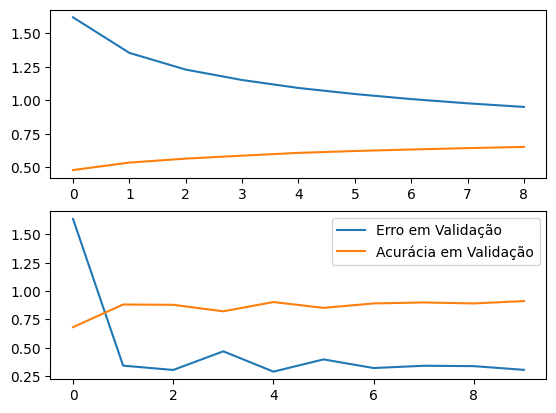

In [ ]:
# Plot
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Erro em Treino')
fig1.plot(total_acc_train, label = 'Acurácia em Treino')
fig2.plot(total_loss_val, label = 'Erro em Validação')
fig2.plot(total_acc_val, label = 'Acurácia em Validação')
plt.legend()
plt.show()

In [ ]:
# Carrega o modelo do disco
modelo_final = torch.load('modelos/modelo_dsa.pth')

> Avaliação do modelo com dados de teste.

In [ ]:
# Coloca o modelo em modo de avaliação
modelo_final.eval()

# Inicializa uma lista para armazenar os rótulos verdadeiros
y_label = []

# Inicializa uma lista para armazenar as predições
y_predict = []

# Desabilita o cálculo de gradientes
with torch.no_grad():

    # Itera sobre o carregador de dados de teste
    for i, data in enumerate(loader_teste):

        # Extrai imagens e rótulos do lote de dados
        images, labels = data

        # Obtém o número de imagens no lote
        N = images.size(0)

        # Envia as imagens para o dispositivo apropriado (GPU ou CPU)
        images = Variable(images).to(device)

        # Calcula as saídas do modelo usando as imagens
        outputs = modelo(images)

        # Obtém as previsões do modelo
        prediction = outputs.max(1, keepdim=True)[1]

        # Adiciona os rótulos verdadeiros à lista
        y_label.extend(labels.cpu().numpy())

        # Adiciona as previsões à lista
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

In [ ]:
# Função de plot da confusion_matrix
def dsa_plot_confusion_matrix(cm,
                              classes,
                              normalize = False,
                              title = 'Confusion matrix',
                              cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto')

In [ ]:
# Cria a confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)

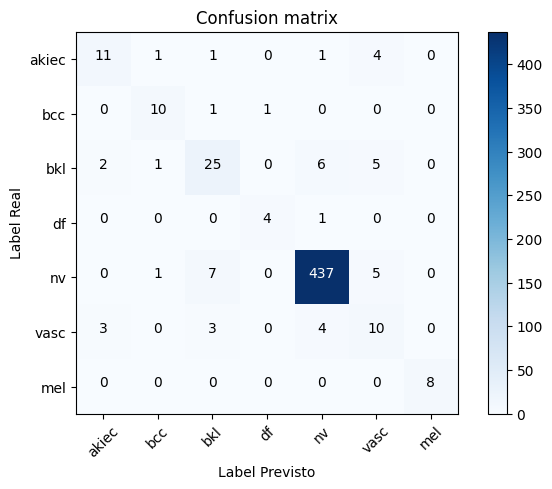

In [ ]:
# Plot da confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
dsa_plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
# Gera o relatório de classificação
report = classification_report(y_label, y_predict, target_names = plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.69      0.61      0.65        18
         bcc       0.77      0.83      0.80        12
         bkl       0.68      0.64      0.66        39
          df       0.80      0.80      0.80         5
          nv       0.97      0.97      0.97       450
        vasc       0.42      0.50      0.45        20
         mel       1.00      1.00      1.00         8

    accuracy                           0.91       552
   macro avg       0.76      0.77      0.76       552
weighted avg       0.92      0.91      0.92       552



Text(0, 0.5, 'Classificação Incorreta')

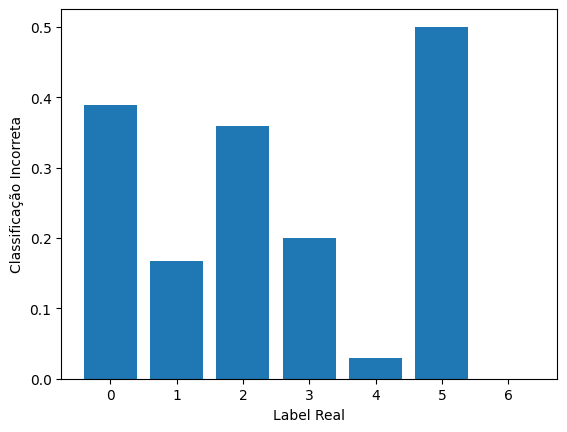

In [ ]:
# Plot de erros por classe
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis = 1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('Label Real')
plt.ylabel('Classificação Incorreta')

## Deploy e Aplicação do Modelo em Novas Imagens

Para o deploy do modelo você deve:

1- Obter novas imagens com lesões da pele.

2- Carregar as imagens.

3- Aplicar nas imagens as mesmas transformações aplicadas nos dados de validação e teste.

4- Carregar o modelo do disco.

5- Usar o modelo treinado e fazer a previsão de classe.

# Fim